tf.data를 이용해 image를 로드하는 방법

In [1]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [2]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 24s 0us/step


In [3]:
data_dir

WindowsPath('C:/Users/jjgk9/.keras/datasets/flower_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [6]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [8]:
roses = list(data_dir.glob('roses/*'))
len(roses)

641

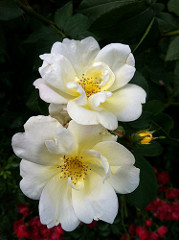

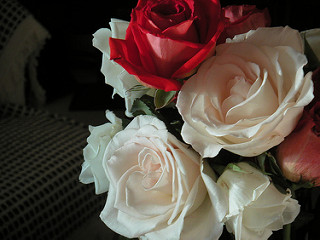

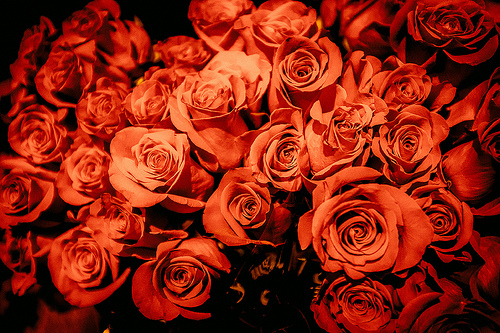

In [9]:
for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## `keras.preprocessing`를 이용하여 로드

In [10]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [12]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [13]:
train_data_gen

In [14]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [16]:
next(train_data_gen)

(array([[[[1.        , 1.        , 1.        ],
          [0.9568628 , 0.9568628 , 0.9568628 ],
          [1.        , 1.        , 1.        ],
          ...,
          [0.9960785 , 0.9960785 , 0.9960785 ],
          [1.        , 1.        , 1.        ],
          [0.9921569 , 0.9921569 , 0.9921569 ]],
 
         [[0.98823535, 0.98823535, 0.98823535],
          [1.        , 1.        , 1.        ],
          [0.5176471 , 0.5176471 , 0.5176471 ],
          ...,
          [0.45098042, 0.45098042, 0.45098042],
          [0.9333334 , 0.9333334 , 0.9333334 ],
          [0.9921569 , 0.9921569 , 0.9921569 ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [0.09019608, 0.09019608, 0.09019608],
          ...,
          [0.        , 0.        , 0.        ],
          [0.854902  , 0.854902  , 0.854902  ],
          [0.9921569 , 0.9921569 , 0.9921569 ]],
 
         ...,
 
         [[0.98823535, 0.98823535, 0.98823535],
          [1.     

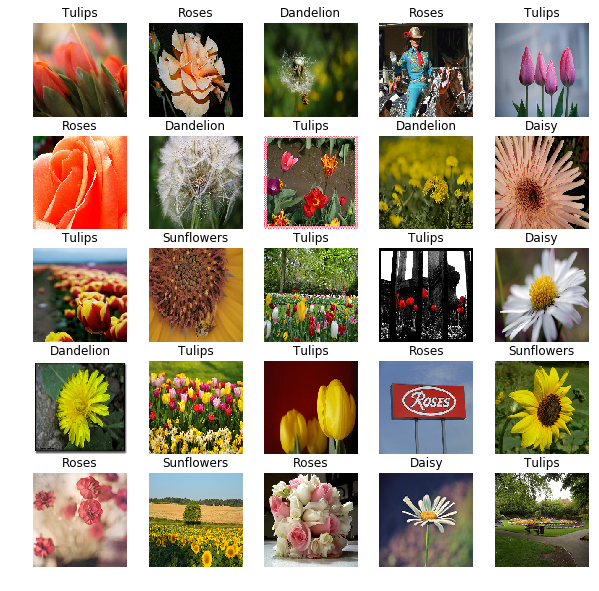

In [15]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## tf.data를 이용한 이미지 로드

In [17]:
data_dir

WindowsPath('C:/Users/jjgk9/.keras/datasets/flower_photos')

In [18]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [19]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\jjgk9\\.keras\\datasets\\flower_photos\\dandelion\\7243174412_d3628e4cc4_m.jpg'
b'C:\\Users\\jjgk9\\.keras\\datasets\\flower_photos\\tulips\\6948239566_0ac0a124ee_n.jpg'
b'C:\\Users\\jjgk9\\.keras\\datasets\\flower_photos\\sunflowers\\1044296388_912143e1d4.jpg'
b'C:\\Users\\jjgk9\\.keras\\datasets\\flower_photos\\tulips\\489506904_9b68ba211c.jpg'
b'C:\\Users\\jjgk9\\.keras\\datasets\\flower_photos\\sunflowers\\4878447831_e904c60cf8_n.jpg'


In [20]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [21]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [22]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [25]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [26]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False False False False]


In [27]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [28]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

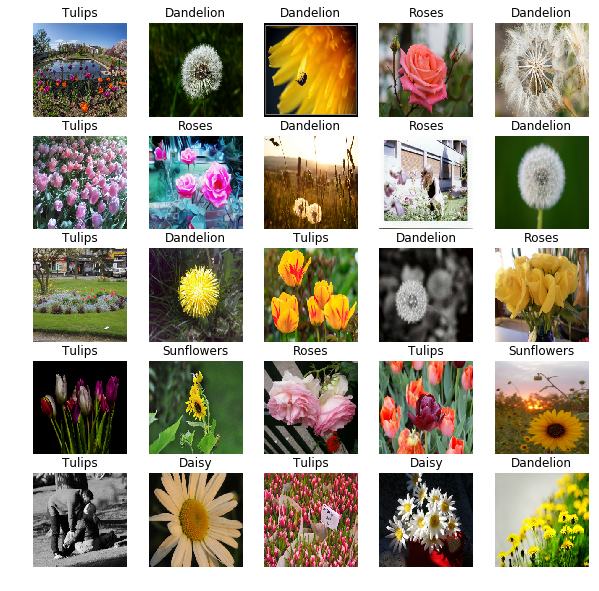

In [29]:
show_batch(image_batch.numpy(), label_batch.numpy())